In [ ]:
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F

from CLIP_Explainability.code.vit_cam import interpret_vit, interpret_vit_overlapped, vit_relevance
from CLIP_Explainability.code.image_utils import show_cam_on_image
import CLIP_Explainability.code.clip_ as clip_
import clip

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model_, preprocess_ = clip_.load("ViT-B/32", device=device, jit=False)

torch.Size([1, 3, 224, 224])


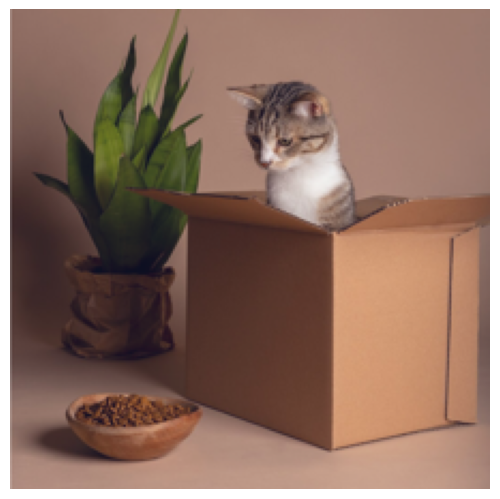

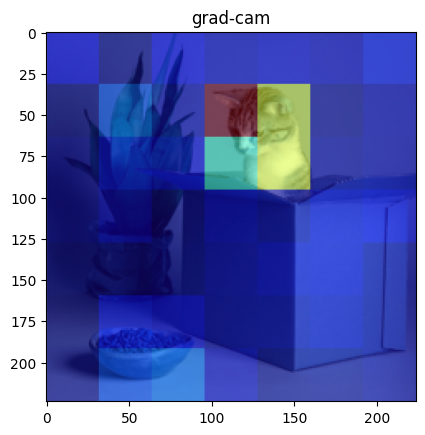

In [33]:
import torch.nn.functional as F
import torchvision

img_path = "/hdd/hdd1/kjc/prompt/cat_box_1.png"
# img_path = "/hdd/hdd1/kjc/prompt/dog_pot_1.png"
# img_path = "/hdd/hdd1/kjc/prompt/dog_frisbee_1.png"
# img_path = "/hdd/hdd1/kjc/prompt/cat_2.png"
# img_path = "/hdd/hdd2/sch/DATA/food-101/images/macarons/1189934.jpg"
# img_path = "/hdd/hdd2/sch/DATA/food-101/images/oysters/3566585.jpg"
# img_path = "/hdd/hdd2/sch/DATA/food-101/images/ice_cream/368047.jpg"

class_names = ["apple_pie","baby_back_ribs","baklava","beef_carpaccio","beef_tartare","beet_salad","beignets","bibimbap","bread_pudding","breakfast_burrito","bruschetta","caesar_salad","cannoli","caprese_salad","carrot_cake","ceviche","cheesecake","cheese_plate","chicken_curry","chicken_quesadilla","chicken_wings","chocolate_cake","chocolate_mousse","churros","clam_chowder","club_sandwich","crab_cakes","creme_brulee","croque_madame","cup_cakes","deviled_eggs","donuts","dumplings","edamame","eggs_benedict","escargots","falafel","filet_mignon","fish_and_chips","foie_gras","french_fries","french_onion_soup","french_toast","fried_calamari","fried_rice","frozen_yogurt","garlic_bread","gnocchi","greek_salad","grilled_cheese_sandwich","grilled_salmon","guacamole","gyoza","hamburger","hot_and_sour_soup","hot_dog","huevos_rancheros","hummus","ice_cream","lasagna","lobster_bisque","lobster_roll_sandwich","macaroni_and_cheese","macarons","miso_soup","mussels","nachos","omelette","onion_rings","oysters","pad_thai","paella","pancakes","panna_cotta","peking_duck","pho","pizza","pork_chop","poutine","prime_rib","pulled_pork_sandwich","ramen","ravioli","red_velvet_cake","risotto","samosa","sashimi","scallops","seaweed_salad","shrimp_and_grits","spaghetti_bolognese","spaghetti_carbonara","spring_rolls","steak","strawberry_shortcake","sushi","tacos","takoyaki","tiramisu","tuna_tartare","waffles"]

# totensor = torchvision.transforms.ToTensor()
img = Image.open(img_path)
img = preprocess_(img).unsqueeze(0).to(device)
img.requires_grad_(True)
img_emb = model_.encode_image(img)
img_emb /= img_emb.norm(dim=-1, keepdim=True)

print(img.shape)

input_noise = torch.randn_like(img, requires_grad=True) / 50
noise_img_emb = model_.encode_image(img + input_noise)
noise_img_emb /= noise_img_emb.norm(dim=-1, keepdim=True)
loss = F.mse_loss(noise_img_emb, img_emb.detach().clone())

# grad = torch.autograd.grad(loss, img)
# vanila_l2_grad_heatmap = torch.abs(grad[0]).detach().cpu()
# vanila_l2_grad_heatmap = vanila_l2_grad_heatmap / torch.max(vanila_l2_grad_heatmap)


# label = torch.LongTensor([class_names.index("ice_cream")]).to(device).view(1)
class_texts = ["a photo of a " + i.replace("_", " ") for i in class_names]
all_tokens = clip.tokenize(np.array(class_texts)).to(device)
tokens = clip.tokenize(np.array(["a photo of a cat"])).to(device)
# tokens = clip.tokenize(np.array(["a photo of a ice_cream"])).to(device)


plt.figure()
plt.axis("off")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
plt.imshow((img / 4 + 0.5 ).cpu().detach().squeeze().permute(1,2,0).numpy())
plt.savefig(f"test.png", transparent=True, bbox_inches="tight", pad_inches=0)
# plt.figure()
# plt.title("l2 grad")
# plt.imshow(vanila_l2_grad_heatmap.detach().squeeze().permute(1,2,0).numpy())
plt.figure()
plt.title("grad-cam")
text_features = model_.encode_text(tokens)
interpret_vit(img.type(model_.dtype), text_features, model_.visual, device, method="gradcam")


torch.Size([2, 512])
torch.Size([2, 512])


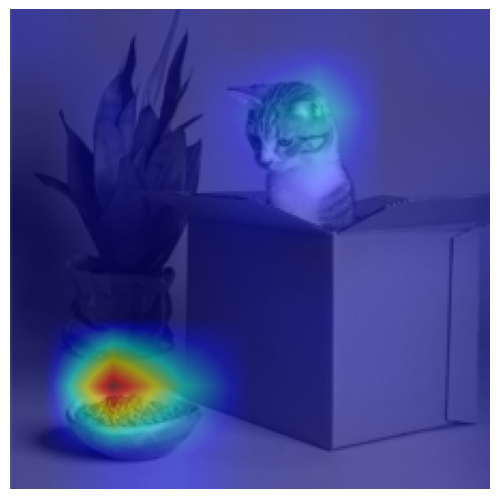

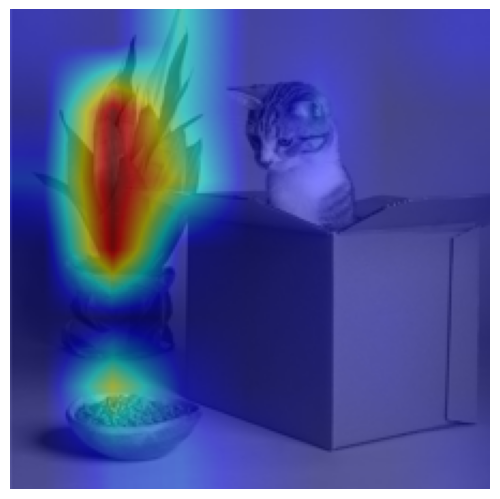

In [40]:

def vit_relevance2(image, target_features, img_encoder, device, method="last grad", neg_saliency=False, custom_objective=None, all_text_features=None):

    img_encoder.eval()
    
    image_features = img_encoder(image)

    image_features_norm = image_features.norm(dim=-1, keepdim=True)
    image_features_new = image_features / image_features_norm
    target_features_norm = target_features.norm(dim=-1, keepdim=True)
    target_features_new = target_features / target_features_norm
    
  
    similarity = image_features_new[0].dot(target_features_new[0])
 
    if custom_objective:
        preds = torch.matmul(image_features_new, all_text_features.permute(1,0))
        preds = torch.nn.functional.softmax(preds, dim=-1)
        weighted_text_feature = torch.matmul(preds, all_text_features)
        image_features_text = image_features_new + weighted_text_feature

        # similarity = image_features_text[0].dot(image_features_new[0].detach())
        similarity = image_features_new[0].dot(image_features_text[0].detach())
        # similarity = image_features_new[0].dot(weighted_text_feature[0].detach())
        # similarity = weighted_text_feature[0].dot(image_features_new[0].detach())
        # similarity = image_features_new[0].dot(image_features_text[0].detach())
        # similarity = image_features_new[0].dot(image_features_new[0].detach())
        # similarity = image_features_text[0].dot(target_features_new[0])
        objective = similarity
    elif neg_saliency:
        objective = 1-similarity
    else:
        objective = similarity
        
    
    img_encoder.zero_grad()
    objective.backward(retain_graph=True)
 
    image_attn_blocks = list(dict(img_encoder.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    
    last_attn = image_attn_blocks[-1].attn_probs.detach()
    last_attn = last_attn.reshape(-1, last_attn.shape[-1], last_attn.shape[-1])
    
    last_grad = image_attn_blocks[-1].attn_grad.detach()
    last_grad = last_grad.reshape(-1, last_grad.shape[-1], last_grad.shape[-1])
    
    cam = last_grad * last_attn
    cam = cam.clamp(min=0).mean(dim=0) 
    image_relevance = cam[0, 1:]
    # image_relevance -= image_relevance.min()
    # image_relevance /= image_relevance.max()
           
    
    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    # image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='nearest')
    image_relevance = image_relevance.reshape(224, 224).data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    return image_relevance, image

test_texts = ["a photo of a feed", "a photo of a toy"]
# test_texts = ["a photo of a dog", "a photo of a cat"]
# test_texts = ["a photo of a macaron", "a photo of a cake"]
# test_texts = ["a photo of a apple", "a photo of a lemon"]
test_tokens = clip.tokenize(np.array(test_texts)).to(device)
test_text_features = model_.encode_text(test_tokens)
print(test_text_features.shape)

tokens = clip.tokenize(np.array(["a photo of a macaron"])).to(device)
text_features = model_.encode_text(tokens)
plt.figure()
plt.axis("off")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
image_relevance_naive, image = vit_relevance2(img.type(model_.dtype), text_features, model_.visual, device, method="gradcam", neg_saliency=False, custom_objective=True, all_text_features=test_text_features)
vis = show_cam_on_image(np.mean(image, axis=2, keepdims=True), image_relevance_naive)
vis = np.uint8(255 * vis)
vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
plt.imshow(vis)
plt.savefig(f"test1.png", transparent=True, bbox_inches="tight", pad_inches=0)


test_texts = ["a photo of a water", "a photo of a plant"]
# test_texts = ["a photo of a orange", "a photo of a blue"]
# test_texts = ["a photo of a pot", "a photo of a ball"]
# test_texts = ["a photo of a dog", "a photo of a ball"]
# test_texts = ["a photo of a coffee", "a photo of a spoon"]
test_tokens = clip.tokenize(np.array(test_texts)).to(device)
test_text_features = model_.encode_text(test_tokens)
print(test_text_features.shape)

tokens = clip.tokenize(np.array(["a photo of a coffee"])).to(device)
text_features = model_.encode_text(tokens)
plt.figure()
plt.axis("off")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
image_relevance_naive, image = vit_relevance2(img.type(model_.dtype), text_features, model_.visual, device, method="gradcam", neg_saliency=False, custom_objective=True, all_text_features=test_text_features)
vis = show_cam_on_image(np.mean(image, axis=2, keepdims=True), image_relevance_naive)
vis = np.uint8(255 * vis)
vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
plt.imshow(vis)
plt.savefig(f"test2.png", transparent=True, bbox_inches="tight", pad_inches=0)
